In [1]:
# load libraries 
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
# set seeds
torch.manual_seed(2020)
np.random.seed(2020)

In [3]:
# load data
train = np.loadtxt("ECG200_TRAIN.txt")
test  = np.loadtxt("ECG200_TEST.txt")

# the first column is label
X_train = train[:, 1:]       
y_train = train[:, 0].astype(int)     
X_test  = test[:, 1:]              
y_test  = test[:, 0].astype(int)

# original label is -1, +1, we convert to 0, 1 for BCE
y_train = (y_train == 1).astype(np.float32)
y_test  = (y_test == 1).astype(np.float32)


# convert to torch tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


print("X_train:", X_train.shape, "y_train:", y_train.shape)

X_train: torch.Size([100, 96]) y_train: torch.Size([100, 1])


In [4]:
# define a baseline NeuralNetwork

class NeuralNetwork1(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(96, 1)
        self.final = nn.Sigmoid()

    def forward(self, x):
        
        op = self.fc1(x)
        y = self.final(op)

        return y   

In [5]:
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(96, 256)
        self.relu1 = nn.ReLU()
        
        self.out = nn.Linear(256, 1)
        self.final = nn.Sigmoid()

    def forward(self, x):
        
        op = self.fc1(x)
        op = self.relu1(op)
        
        op = self.out(op)
        y = self.final(op)

        return y      

In [6]:
def train_network(model, optimizer, loss_fn, num_epochs, batch_size, X_train, y_train, X_test, y_test):


    # record history
    train_loss_history = []
    test_loss_history  = []
    train_acc_history  = []
    test_acc_history   = []



    # training size
    N = X_train.shape[0]

    for epoch in range(num_epochs):
        
        # explicitly start model training
        model.train()

        for i in range(0, N, batch_size):

            # end index for each batch
            end = min(N, i + batch_size)

            # extract train batch from X and Y
            x_batch = X_train[i:end]
            y_batch = y_train[i:end]

            # set the gradients to zero before starting to do backpropragation
            optimizer.zero_grad()

            # forward pass
            y_pred = model(x_batch)

            # # caculate loss
            loss = loss_fn(y_pred, y_batch)

            # backpropogate
            loss.backward()

            # update weights
            optimizer.step()



        # explicitly set to evaluate mode
        model.eval()
        with torch.no_grad():

            # Train set
            train_prob = model(X_train)
            train_loss = loss_fn(train_prob, y_train).item()
            train_pred = (train_prob >= 0.5).float()
            train_acc  = (train_pred == y_train).float().mean().item()

            # Test set
            test_prob = model(X_test)
            test_loss = loss_fn(test_prob, y_test).item()
            test_pred = (test_prob >= 0.5).float()
            test_acc  = (test_pred == y_test).float().mean().item()

        train_loss_history.append(train_loss) 
        test_loss_history.append(test_loss)
        train_acc_history.append(train_acc)
        test_acc_history.append(test_acc)

        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d} | TrainLoss={train_loss:.4f} | TestLoss={test_loss:.4f} | TrainAcc={train_acc:.3f} | TestAcc={test_acc:.3f}")

    return train_loss_history, test_loss_history, train_acc_history, test_acc_history


In [7]:
def plot_loss_and_accuracy(train_loss, test_loss, train_acc, test_acc):
    plt.figure(figsize=(12, 4))

    # loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(test_loss,  label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Test Loss")
    plt.legend()

    # accuracy 
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(test_acc,  label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Test Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [8]:
# hyperparameters
num_epochs = 200
batch_size = 16
weight_decay = 0.0
learning_rate = 0.001

# binary Crosss Entropy Loss
loss_function = nn.BCELoss()

In [9]:
# create a model instance
model1 = NeuralNetwork1()

# print the model size (number of parameters)
num_params = sum(p.numel() for p in model1.parameters())
print("Number of parameters:", num_params)

Number of parameters: 97


In [10]:
# define optimizer1
optimizer1 = torch.optim.Adam(model1.parameters(), lr = learning_rate, weight_decay = weight_decay)

# train model1
train_loss, test_loss, train_acc, test_acc = train_network(model1, optimizer1, loss_function, num_epochs, batch_size, X_train, y_train, X_test, y_test)

Epoch   0 | TrainLoss=0.5805 | TestLoss=0.5805 | TrainAcc=0.780 | TestAcc=0.780
Epoch  10 | TrainLoss=0.3932 | TestLoss=0.4403 | TrainAcc=0.820 | TestAcc=0.790
Epoch  20 | TrainLoss=0.3500 | TestLoss=0.4209 | TrainAcc=0.850 | TestAcc=0.760
Epoch  30 | TrainLoss=0.3263 | TestLoss=0.4103 | TrainAcc=0.840 | TestAcc=0.760
Epoch  40 | TrainLoss=0.3102 | TestLoss=0.4030 | TrainAcc=0.850 | TestAcc=0.780
Epoch  50 | TrainLoss=0.2981 | TestLoss=0.3976 | TrainAcc=0.850 | TestAcc=0.790
Epoch  60 | TrainLoss=0.2883 | TestLoss=0.3938 | TrainAcc=0.860 | TestAcc=0.800
Epoch  70 | TrainLoss=0.2801 | TestLoss=0.3910 | TrainAcc=0.860 | TestAcc=0.800
Epoch  80 | TrainLoss=0.2730 | TestLoss=0.3890 | TrainAcc=0.850 | TestAcc=0.800
Epoch  90 | TrainLoss=0.2668 | TestLoss=0.3876 | TrainAcc=0.850 | TestAcc=0.810
Epoch 100 | TrainLoss=0.2611 | TestLoss=0.3867 | TrainAcc=0.840 | TestAcc=0.810
Epoch 110 | TrainLoss=0.2560 | TestLoss=0.3861 | TrainAcc=0.850 | TestAcc=0.810
Epoch 120 | TrainLoss=0.2513 | TestLoss=

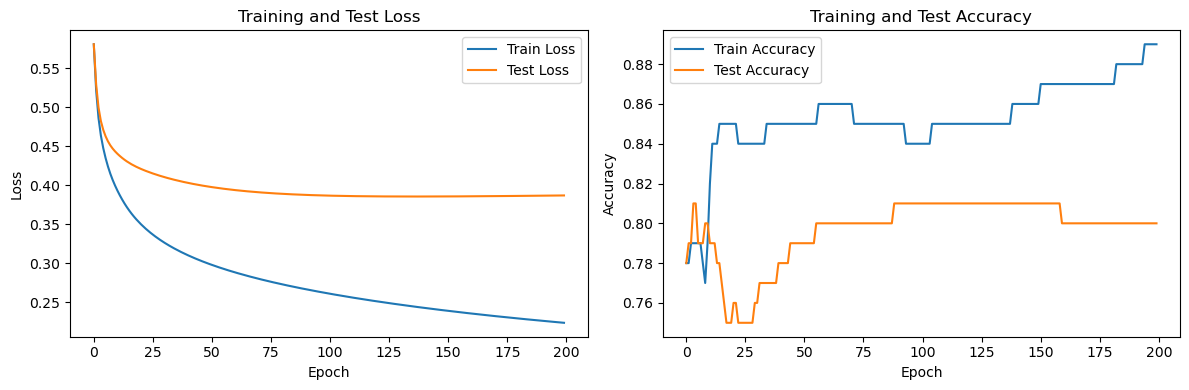

In [11]:
# plot model1
plot_loss_and_accuracy(train_loss, test_loss, train_acc, test_acc)

In [12]:
# create a model instance
model2 = NeuralNetwork2()

# print the model size (number of parameters)
num_params = sum(p.numel() for p in model2.parameters())
print("Number of parameters:", num_params)

Number of parameters: 25089


In [13]:
# define optimizer2
optimizer2 = torch.optim.Adam(model2.parameters(), lr = learning_rate, weight_decay = weight_decay)

In [14]:
# train model2
train_loss, test_loss, train_acc, test_acc = train_network(model2, optimizer2, loss_function, num_epochs, batch_size, X_train, y_train, X_test, y_test)

Epoch   0 | TrainLoss=0.4724 | TestLoss=0.4950 | TrainAcc=0.760 | TestAcc=0.800
Epoch  10 | TrainLoss=0.2161 | TestLoss=0.3440 | TrainAcc=0.900 | TestAcc=0.820
Epoch  20 | TrainLoss=0.1399 | TestLoss=0.3314 | TrainAcc=0.940 | TestAcc=0.850
Epoch  30 | TrainLoss=0.0894 | TestLoss=0.3196 | TrainAcc=0.980 | TestAcc=0.880
Epoch  40 | TrainLoss=0.0566 | TestLoss=0.3185 | TrainAcc=1.000 | TestAcc=0.870
Epoch  50 | TrainLoss=0.0364 | TestLoss=0.3262 | TrainAcc=1.000 | TestAcc=0.870
Epoch  60 | TrainLoss=0.0242 | TestLoss=0.3396 | TrainAcc=1.000 | TestAcc=0.880
Epoch  70 | TrainLoss=0.0168 | TestLoss=0.3531 | TrainAcc=1.000 | TestAcc=0.880
Epoch  80 | TrainLoss=0.0122 | TestLoss=0.3680 | TrainAcc=1.000 | TestAcc=0.880
Epoch  90 | TrainLoss=0.0092 | TestLoss=0.3822 | TrainAcc=1.000 | TestAcc=0.890
Epoch 100 | TrainLoss=0.0070 | TestLoss=0.3956 | TrainAcc=1.000 | TestAcc=0.890
Epoch 110 | TrainLoss=0.0056 | TestLoss=0.4087 | TrainAcc=1.000 | TestAcc=0.890
Epoch 120 | TrainLoss=0.0045 | TestLoss=

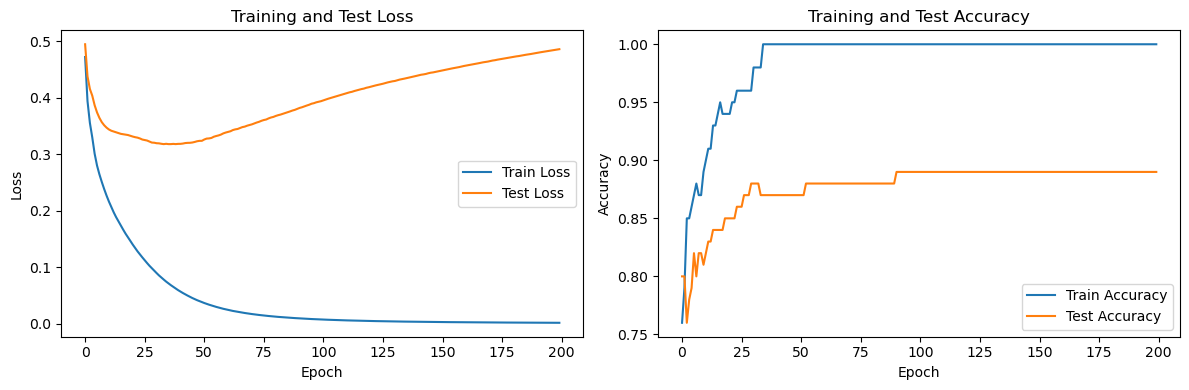

In [15]:
# plot model2
plot_loss_and_accuracy(train_loss, test_loss, train_acc, test_acc)

In [22]:
def train_and_score(hidden_dim = 256, learning_rate = 0.001, weight_decay = 0.0, batch_size = 16, num_epochs = 200):
 
    
    model = NeuralNetwork2() 

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_loss, test_loss, train_acc, test_acc = train_network(model, optimizer, loss_function, num_epochs, batch_size, X_train, y_train, X_test, y_test)

    # best test accuracy
    best_test_acc = float(np.max(test_acc))
    best_epoch = int(np.argmax(test_acc))
    final_test_acc = float(test_acc[-1])
    final_test_loss = float(test_loss[-1])

    return {
        "lr": learning_rate,
        "weight_decay": weight_decay,
        "batch_size": batch_size,
        "best_test_acc": best_test_acc,
        "best_epoch": best_epoch,
        "final_test_acc": final_test_acc,
        "final_test_loss": final_test_loss
    }



lr_list = [0.001, 0.0005, 0.0001]
wd_list = [0.0, 0.0001, 0.001, 0.01, 0.05]
bs_list = [8, 16]

all_results = []

for lr in lr_list:
    for wd in wd_list:
        for bs in bs_list:
            print(f"\nRunning: lr={lr}, wd={wd}, bs={bs}")
            r = train_and_score(learning_rate=lr, weight_decay=wd, batch_size=bs, num_epochs=200)
            all_results.append(r)
            print(f"  -> best_test_acc={r['best_test_acc']:.3f} (epoch {r['best_epoch']})")

# best best_test_acc
best = max(all_results, key=lambda x: x["best_test_acc"])
print("\n BEST CONFIG")
print(best)

# sort result by accuracy
all_results_sorted = sorted(all_results, key=lambda x: x["best_test_acc"], reverse=True)
print("\n Top 5 configs:")
for r in all_results_sorted[:5]:
    print(r)



Running: lr=0.001, wd=0.0, bs=8
Epoch   0 | TrainLoss=0.4358 | TestLoss=0.4752 | TrainAcc=0.760 | TestAcc=0.790
Epoch  10 | TrainLoss=0.1643 | TestLoss=0.3355 | TrainAcc=0.930 | TestAcc=0.840
Epoch  20 | TrainLoss=0.0836 | TestLoss=0.3169 | TrainAcc=0.990 | TestAcc=0.860
Epoch  30 | TrainLoss=0.0425 | TestLoss=0.3189 | TrainAcc=1.000 | TestAcc=0.880
Epoch  40 | TrainLoss=0.0230 | TestLoss=0.3363 | TrainAcc=1.000 | TestAcc=0.880
Epoch  50 | TrainLoss=0.0136 | TestLoss=0.3606 | TrainAcc=1.000 | TestAcc=0.890
Epoch  60 | TrainLoss=0.0088 | TestLoss=0.3827 | TrainAcc=1.000 | TestAcc=0.890
Epoch  70 | TrainLoss=0.0060 | TestLoss=0.4032 | TrainAcc=1.000 | TestAcc=0.890
Epoch  80 | TrainLoss=0.0044 | TestLoss=0.4218 | TrainAcc=1.000 | TestAcc=0.890
Epoch  90 | TrainLoss=0.0033 | TestLoss=0.4392 | TrainAcc=1.000 | TestAcc=0.890
Epoch 100 | TrainLoss=0.0026 | TestLoss=0.4539 | TrainAcc=1.000 | TestAcc=0.890
Epoch 110 | TrainLoss=0.0021 | TestLoss=0.4686 | TrainAcc=1.000 | TestAcc=0.890
Epoch 1

In [23]:
import pandas as pd

results_df = pd.DataFrame(all_results)
results_df


,lr,weight_decay,batch_size,best_test_acc,best_epoch,final_test_acc,final_test_loss
0,0.0010,0.0000,8,0.89,47,0.89,0.560999
1,0.0010,0.0000,16,0.89,44,0.89,0.484524
2,0.0010,0.0001,8,0.90,190,0.89,0.504539
3,0.0010,0.0001,16,0.90,194,0.90,0.461570
4,0.0010,0.0010,8,0.90,107,0.90,0.345449
5,0.0010,0.0010,16,0.90,189,0.90,0.330811
6,0.0010,0.0100,8,0.87,33,0.87,0.281983
7,0.0010,0.0100,16,0.89,168,0.89,0.265889
8,0.0010,0.0500,8,0.86,34,0.86,0.294416
9,0.0010,0.0500,16,0.86,43,0.86,0.293693


In [24]:
results_df.to_csv("hyperparameter_search_results.csv", index=False)
print("Results saved to hyperparameter_search_results.csv")


Results saved to hyperparameter_search_results.csv
